<a id=contents></a>

# Extraction and cleaning notebook
## Data retrieved from glassdoor.com

Data was extracted via Glassdoor's REST API (documentation here: https://www.glassdoor.com/developer/index.htm). 

[1. Data Inspection](#insp)

[2. Cleaning text data](#text)

In [1]:
import pandas as pd
import numpy as np
import os
import time
import requests as req
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import string

from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)
import bs4
from bs4 import BeautifulSoup

import warnings
import sqlalchemy
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine


%load_ext autoreload
%autoreload 2

<a id=insp ><a/> 

## 1. Data Inspection
    
[LINK to table of contents](#contents)

Now that we have a list of strings, we can check the length, the size of string and what the most frequent terms will be, which'll give us an insight into what we need to clean.

In [2]:
ds_jobs = pd.read_pickle('ds_jobs_raw_london.pkl')
ds_jobs.head()

,company,job_titles_lst,job_descr,job_post_html,job_search_term,job_url
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,We would like to reassure all applicants that ...,"[[[\n, <title>CPRD Data Scientist - London - I...",data scientist,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...
1,"PwC7,678 reviews",Deals - Investigative Analytics - Data Scienti...,"A career within Forensics Technology services,...","[[[\n, <title>Deals - Investigative Analytics ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...
2,"Capital One - UK8,902 reviews",Data Scientist - Cyber,"White Collar Factory (95009), United Kingdom, ...","[[[\n, <title>Data Scientist - Cyber - London ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...
3,Globant,Lead Data Scientist,We are a digitally native technology services ...,"[[[\n, <title>Lead Data Scientist - London EC1...",data scientist,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...
4,UK Government - National Crime Agency32 reviews,G4 Lead Data Scientist - Cyber,Deploy analytical capabilities in support of o...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",data scientist,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...


In [3]:
ds_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   company          666 non-null    object
 1   job_titles_lst   666 non-null    object
 2   job_descr        666 non-null    object
 3   job_post_html    666 non-null    object
 4   job_search_term  666 non-null    object
 5   job_url          666 non-null    object
dtypes: object(6)
memory usage: 31.3+ KB


In [4]:
ds_jobs.job_descr.nunique()

545

In [5]:
ds_jobs.job_url.nunique()

666

It's very odd that we'd see different numbers of duplicates between the two columnns. Given that it's the text we're most interested in, we're gonna drop duplicates via the job description column first.

In [6]:
ds_jobs.drop_duplicates(inplace=True, subset='job_descr')

In [7]:
ds_jobs.shape

(545, 6)

In [8]:
ds_jobs.head()

,company,job_titles_lst,job_descr,job_post_html,job_search_term,job_url
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,We would like to reassure all applicants that ...,"[[[\n, <title>CPRD Data Scientist - London - I...",data scientist,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...
1,"PwC7,678 reviews",Deals - Investigative Analytics - Data Scienti...,"A career within Forensics Technology services,...","[[[\n, <title>Deals - Investigative Analytics ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...
2,"Capital One - UK8,902 reviews",Data Scientist - Cyber,"White Collar Factory (95009), United Kingdom, ...","[[[\n, <title>Data Scientist - Cyber - London ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...
3,Globant,Lead Data Scientist,We are a digitally native technology services ...,"[[[\n, <title>Lead Data Scientist - London EC1...",data scientist,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...
4,UK Government - National Crime Agency32 reviews,G4 Lead Data Scientist - Cyber,Deploy analytical capabilities in support of o...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",data scientist,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...


In [9]:
ds_jobs.rename(columns={'job_titles_lst':'job_title'}, inplace=True)
ds_jobs.head()

,company,job_title,job_descr,job_post_html,job_search_term,job_url
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,We would like to reassure all applicants that ...,"[[[\n, <title>CPRD Data Scientist - London - I...",data scientist,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...
1,"PwC7,678 reviews",Deals - Investigative Analytics - Data Scienti...,"A career within Forensics Technology services,...","[[[\n, <title>Deals - Investigative Analytics ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...
2,"Capital One - UK8,902 reviews",Data Scientist - Cyber,"White Collar Factory (95009), United Kingdom, ...","[[[\n, <title>Data Scientist - Cyber - London ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...
3,Globant,Lead Data Scientist,We are a digitally native technology services ...,"[[[\n, <title>Lead Data Scientist - London EC1...",data scientist,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...
4,UK Government - National Crime Agency32 reviews,G4 Lead Data Scientist - Cyber,Deploy analytical capabilities in support of o...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",data scientist,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...


Important to give the frequency of terms a quick gland and see what is dominating our vocabulary. At this basic EDA stage we can pick up a lot of the unclean data.

## 1.1 Term distribution

In [10]:
def plot_freqdist_from_series(pd_series, tokenizer_obj, stop_words_list, title = 'Term Frequency distribution', num_terms=20, figsize = (10,10)):
    """Function that takes in a Pandas Series or column of a DataFrame and plots the Frequency Distribution
    of termns within that list of documents.
    Args:
    pd_series - either a standalone Pandas Series object or a dataframe column, e.g. df.job_description
    tokenizer_obj - (obj) a tokenizer object, normally of the NLTK variety
    num_terms - (int) how many of the top terms to plot on the Freq Dist, default 20
    stop_words - (list of str) list of stop words to exclude from final corpus
    figsize - (tuple of 2 integers) size of matplotlib plot, default is (10,10)
    
    Returns:
    a plot of the Frequency Distribution of the words in the corpus, using NLTK's built in FreqDist function.
    """
    job_descr_list = [text for text in pd_series.values]
    
    for job in job_descr_list:
        tokenized_job = tokenizer.tokenize(job)
        final_str = [word.lower() for word in tokenized_job if word.lower() not in stop_words_list]

    f_dist = FreqDist([word.lower() for word in final_str]);
    plt.figure(figsize=figsize)
    plt.title(title)
    f_dist.plot(num_terms)
    plt.show();
    return


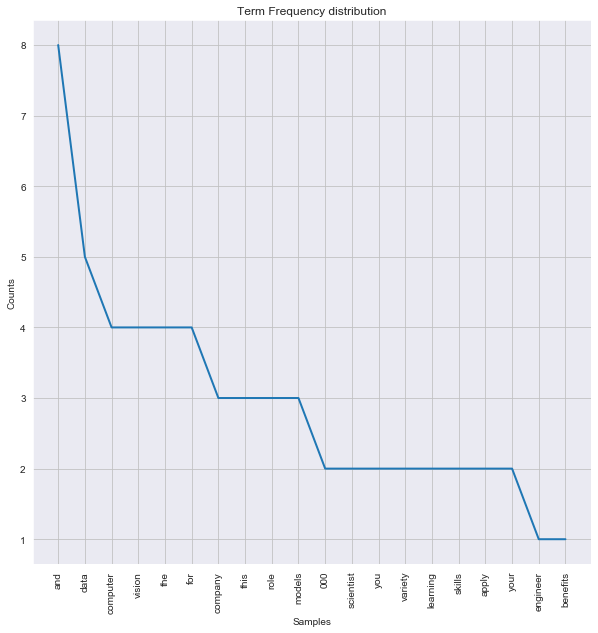

In [11]:
f = plot_freqdist_from_series(ds_jobs.job_descr, tokenizer, stop_words_list=[])


Now let's see what our data would look like without stop words.

In [12]:
set(stop_words)

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

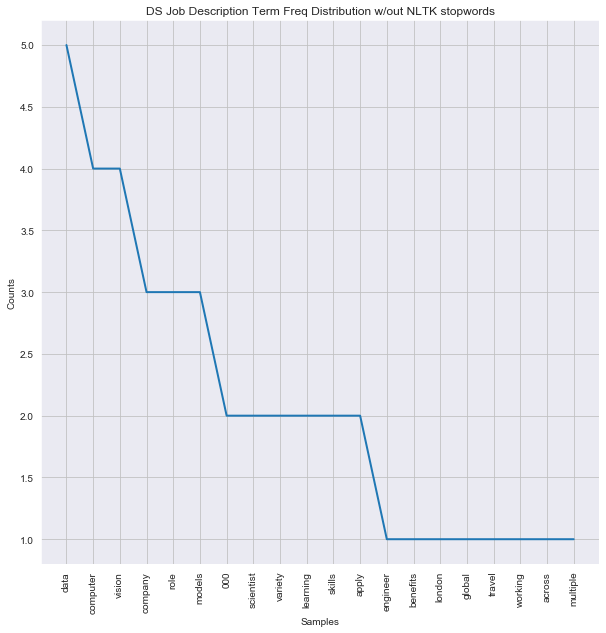

In [13]:
plot_freqdist_from_series(ds_jobs.job_descr, tokenizer, stop_words_list=set(stop_words), title='DS Job Description Term Freq Distribution w/out NLTK stopwords')

Ok, so with this distribution in mind it seems that we're getting much, much cleaner data and our tokenizer seems to have parsed through a lot of potential rubbish. A good question would be whether we want to include 'data' or not. For the purpose of comparing later to the ML Eng data, let's keep it in. We will now explore the ML Eng data similarly. 

In [14]:
mleng_jobs = pd.read_pickle('mleng_jobs_raw_london.pkl')
print(mleng_jobs.nunique())
mleng_jobs.head()

company            298
job_title          559
job_descr          680
job_post_html      812
job_search_term      1
job_url            812
dtype: int64


,company,job_title,job_descr,job_post_html,job_search_term,job_url
0,Spotify59 reviews,Machine Learning Engineer – Search,The Personalization team makes deciding what t...,"[[[\n, <title>Machine Learning Engineer – Sear...",machine learning engineer,https://www.indeed.co.uk/rc/clk?jk=adc2d336aec...
1,Transformative AI,Research Scientist - Machine Learning,ABOUT TRANSFORMATIVEBorn out of CERN and the U...,"[[[\n, <title>Research Scientist - Machine Lea...",machine learning engineer,https://www.indeed.co.uk/company/Transformativ...
2,Echobox,Junior Machine Learning Engineer - London,Echobox has access to very large granular priv...,"[[[\n, <title>Junior Machine Learning Engineer...",machine learning engineer,https://www.indeed.co.uk/rc/clk?jk=110484a7c65...
3,OakNorth Bank,"Engineer, Machine Learning",OakNorth is the next-generation credit and mon...,"[[[\n, <title>Engineer, Machine Learning - Lon...",machine learning engineer,https://www.indeed.co.uk/rc/clk?jk=4c460bbd6a3...
4,NP Group,Machine Learning Scientist,Machine Learning Scientist - London - Investme...,"[[[\n, <title>Machine Learning Scientist - Lon...",machine learning engineer,https://www.indeed.co.uk/rc/clk?jk=6f06b212bad...


In [15]:
mleng_jobs.drop_duplicates('job_descr', inplace=True)

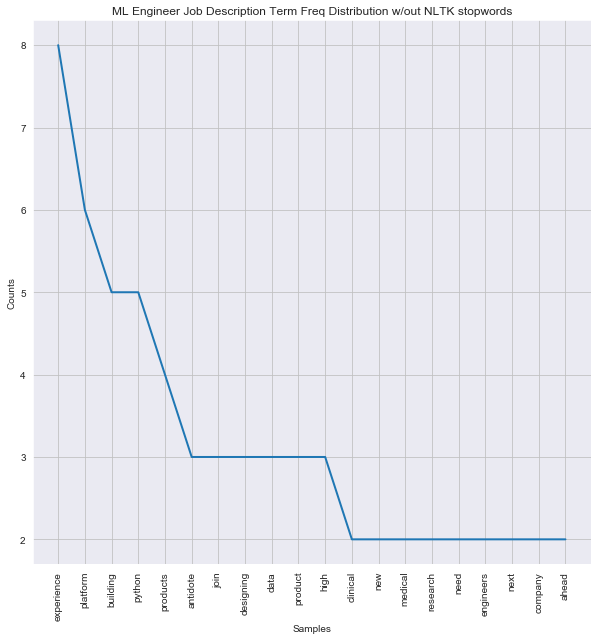

In [16]:
plot_freqdist_from_series(mleng_jobs.job_descr, tokenizer, stop_words_list=set(stop_words), title='ML Engineer Job Description Term Freq Distribution w/out NLTK stopwords')

So now we can see that there are clearly some common words with very little value. Although this is down to the discretion of the individual data scientist / analyst exploring this data, I think we want to trim down on the highly common words, because they don't offer much distinctive information. If we look at the figure above and the last one for the DS jobs, we will see that the frequency distribution starts mentioning languages (only 'python' so far, but it's a start) - if we can glean more detailed info such as what programming languages and packages ML Engs and DS's are supposed to have, then we'll have a much more informative dataset to feed into future models and exploration. Therefore, we will be adding trimming a set of 'uninformative_terms' - the kind that we'd expect to see across the board in both types of posts and also in 

In [17]:
stop_words

['why',
 "don't",
 'hers',
 'yourself',
 'are',
 'weren',
 "you'd",
 'above',
 'it',
 'were',
 "isn't",
 'when',
 'too',
 'don',
 'o',
 'a',
 'doesn',
 'all',
 "couldn't",
 'until',
 "won't",
 'where',
 'those',
 'do',
 "you've",
 'through',
 'just',
 'i',
 'couldn',
 'with',
 "aren't",
 'myself',
 'shan',
 'at',
 'more',
 'further',
 'y',
 've',
 'ours',
 'we',
 "shan't",
 'any',
 'who',
 'she',
 'd',
 'be',
 'not',
 'my',
 'below',
 'haven',
 'he',
 'to',
 'what',
 "didn't",
 'into',
 'm',
 'these',
 'so',
 'wasn',
 "you'll",
 'the',
 'before',
 'am',
 'nor',
 'whom',
 "wouldn't",
 'no',
 'was',
 'ma',
 'have',
 'down',
 'ain',
 'is',
 'ourselves',
 'doing',
 'being',
 'few',
 'after',
 'won',
 'how',
 'its',
 "shouldn't",
 'as',
 'each',
 'her',
 'both',
 'aren',
 'if',
 'then',
 's',
 'did',
 'your',
 'on',
 'does',
 'once',
 "it's",
 "that'll",
 'against',
 "hasn't",
 "weren't",
 'some',
 'for',
 't',
 'theirs',
 "haven't",
 'having',
 'our',
 'had',
 'an',
 'most',
 'again',
 'on

In [18]:
additional_sw = ['data', 'experience', 'learning', 'science', 'machine', 'work', 'company', 'role', 'the', 'skills', ' data', '000', "data", "the", 'join', 'you']
new_stop_words = stop_words
for sw in additional_sw:
    new_stop_words.append(sw)

In [19]:
new_stop_words

['why',
 "don't",
 'hers',
 'yourself',
 'are',
 'weren',
 "you'd",
 'above',
 'it',
 'were',
 "isn't",
 'when',
 'too',
 'don',
 'o',
 'a',
 'doesn',
 'all',
 "couldn't",
 'until',
 "won't",
 'where',
 'those',
 'do',
 "you've",
 'through',
 'just',
 'i',
 'couldn',
 'with',
 "aren't",
 'myself',
 'shan',
 'at',
 'more',
 'further',
 'y',
 've',
 'ours',
 'we',
 "shan't",
 'any',
 'who',
 'she',
 'd',
 'be',
 'not',
 'my',
 'below',
 'haven',
 'he',
 'to',
 'what',
 "didn't",
 'into',
 'm',
 'these',
 'so',
 'wasn',
 "you'll",
 'the',
 'before',
 'am',
 'nor',
 'whom',
 "wouldn't",
 'no',
 'was',
 'ma',
 'have',
 'down',
 'ain',
 'is',
 'ourselves',
 'doing',
 'being',
 'few',
 'after',
 'won',
 'how',
 'its',
 "shouldn't",
 'as',
 'each',
 'her',
 'both',
 'aren',
 'if',
 'then',
 's',
 'did',
 'your',
 'on',
 'does',
 'once',
 "it's",
 "that'll",
 'against',
 "hasn't",
 "weren't",
 'some',
 'for',
 't',
 'theirs',
 "haven't",
 'having',
 'our',
 'had',
 'an',
 'most',
 'again',
 'on

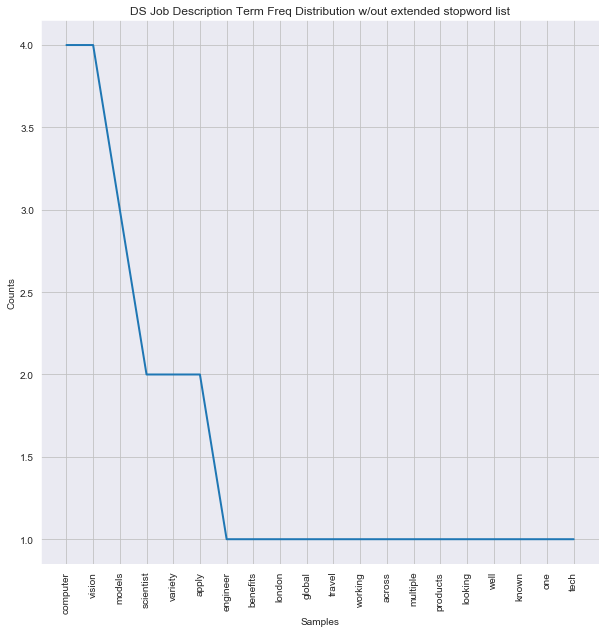

In [20]:
plot_freqdist_from_series(ds_jobs.job_descr, tokenizer, stop_words_list=new_stop_words, title='DS Job Description Term Freq Distribution w/out extended stopword list')

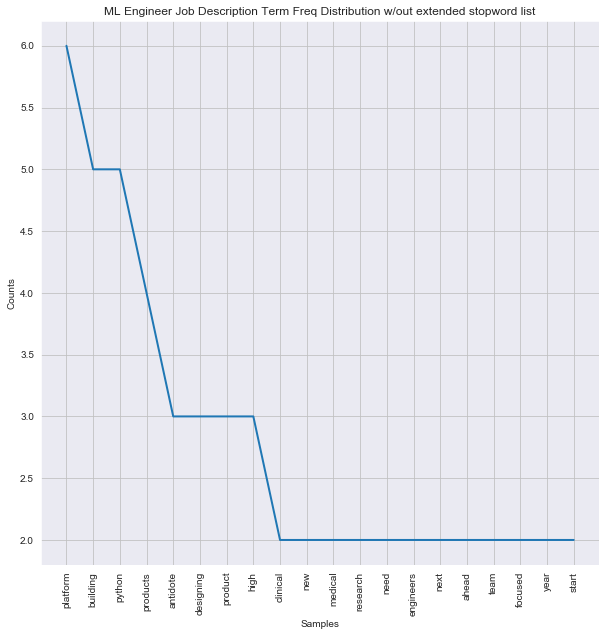

In [21]:
plot_freqdist_from_series(mleng_jobs.job_descr, tokenizer, stop_words_list=new_stop_words, title='ML Engineer Job Description Term Freq Distribution w/out extended stopword list')

We'll merge the data sets now, but adding a categorical column for ML engineering job posts, using pd.get_dummies and the column prefix to indicate the search term. 

In [22]:
df = pd.concat([ds_jobs, mleng_jobs], axis=0)
df.shape

(1225, 6)

In [23]:
df.nunique()

company             450
job_title           810
job_descr          1065
job_post_html      1225
job_search_term       2
job_url            1049
dtype: int64

So ultimately we have 1065 unique job posts after dropping duplicates within both categories.
We would expect to see some job posts that came up in both searches. Since the URL and job_search_term variables can track which came from where, we will leave them in for now and look at them later in more detail.

In [24]:
merged_jobs = pd.get_dummies(df, columns=['job_search_term'], prefix='searched_')


In [25]:
merged_jobs.head()

,company,job_title,job_descr,job_post_html,job_url,searched__data scientist,searched__machine learning engineer
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,We would like to reassure all applicants that ...,"[[[\n, <title>CPRD Data Scientist - London - I...",https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0
1,"PwC7,678 reviews",Deals - Investigative Analytics - Data Scienti...,"A career within Forensics Technology services,...","[[[\n, <title>Deals - Investigative Analytics ...",https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0
2,"Capital One - UK8,902 reviews",Data Scientist - Cyber,"White Collar Factory (95009), United Kingdom, ...","[[[\n, <title>Data Scientist - Cyber - London ...",https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,1,0
3,Globant,Lead Data Scientist,We are a digitally native technology services ...,"[[[\n, <title>Lead Data Scientist - London EC1...",https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,1,0
4,UK Government - National Crime Agency32 reviews,G4 Lead Data Scientist - Cyber,Deploy analytical capabilities in support of o...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,1,0


In [26]:
merged_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225 entries, 0 to 705
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   company                              1225 non-null   object
 1   job_title                            1225 non-null   object
 2   job_descr                            1225 non-null   object
 3   job_post_html                        1225 non-null   object
 4   job_url                              1225 non-null   object
 5   searched__data scientist             1225 non-null   uint8 
 6   searched__machine learning engineer  1225 non-null   uint8 
dtypes: object(5), uint8(2)
memory usage: 59.8+ KB


## 1.2 Salary data extraction

Let's have a look at the job dom and see if we can extract any additional info from there.

In [27]:
testsoup = BeautifulSoup(str(merged_jobs.job_post_html[7].values[0]), 'html')
testsoupstr = testsoup.get_text()
salary_tokenizer = RegexpTokenizer('£[0-9]+,[0-9]+')
salaries = salary_tokenizer.tokenize(testsoupstr)
salaries

['£55,000', '£80,000', '£55,000', '£80,000', '£55,000', '£80,000']

## Limitations, assumptions and solutions for salary data

The get_salary function went through multiple iterations and tests. In the end, several problems occurred that had to be solved as follows:
 * some salaries (<100) were stated in terms of per day/week/month --> for every loop of the function I've checked for the presence of the time period formulation (e.g. "an hour", "a week") so that the fn can decide what time period the salary is stated for
 * there were some job posts with no salary data but a mention of research budget or some other auxiliary financial amount later down in the web page's body. I decided to only retrieve string where a time period like 'a year' were explicitly mentioned, since Indeed.co.uk's job post page structure seems to always mention a time period (when a salary is declared of course)
 * originally I had decided to multiple all weekly salaries by 52, monthly by 12 and so on. However, I realised that I was making increasingly more assumptions about the salaries and these would depend on whether the job was contract or not, whether it was 5 days a week or not, etc. Therefore, I decided to change all the data to hourly, since then the final value would reflect the value of the employee's hourly work. Of course the yearly salaries are most likely for jobs that include holiday pay but I would argue that that is an active contributor to the value a company places on its employee. 
 * for the sake of clarity and easier data wrangling in the future, I include the original and the converted salary and I also decided to return a single character string stating which time period was detected within the text. These will both be stored within the dataframe
 * For the conversion factors, I took, as my baseline, the most up to date estimate of average weekly working hours. This was taken from the ONS for the period January - March 2020. I believe this data to be adequate for these purposes. In the event that the ONS publishes weekly hours for the IT sector, I'll update the conversion factors.
 
 ONS:
 
https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/timeseries/ybuy/lms

In [28]:
def get_salary(dom, parser = 'html', regex_pattern_salary = ['£[0-9]*[,]*[0-9]+[ ]+[a]+'], 
               regex_pattern_interval=['£[0-9]*[,]*[0-9]+[ ]+[a]*[ ]+year', 
                                       '£[0-9]*[,]*[0-9]+[ ]+[a]*[ ]+month', 
                                       '£[0-9]*[,]*[0-9]+[ ]+[a]*[ ]+week',
                                       '£[0-9]*[,]*[0-9]+[ ]+[a]*[ ]+day',
                                       '£[0-9]*[,]*[0-9]+[ ]+[an]*[ ]+hour'],
              ):
    """Function that should be applied across the elements of a column in a pandas dataframe. 
    Parses a webpages html code using BeautifulSoup and a specified parser, after which it tries to identify
    salary mentions using regex. If multiple pattern occurrences are found, the function will return the 
    mean of the first two, based on the assumption that the web page would feature a string similar to :
     - Salary range: £25,000 - £32,000
     Args:
     dom - block of html code
     parser - (str) parser that BeautifulSoup should use, e.g. 'html' (default) or 'lxml'
     regex_pattern_salary - (list of str) lis of patterns for regex to use for retrieving the numerical data
     regex_pattern_interval - (list of str) list of patterns for regex to use for determining if the salary is
                            per year, per week, per month.
     
     Returns a TUPLE:
     salaries_final - (int) a single value of salary
     salary_period - (str) for what time period the salary is declared for: Y - per year; 
                         M - per month, H - per hour, W - per week, D - per day
     """
    dom = str(dom)
    soup = BeautifulSoup(dom, parser)
    # BS4 used to parse the dom and just retrieve the text, eliminating any html tags
    soup_str = soup.get_text()
    for regex_pattern in regex_pattern_salary:
        # iterating over the text using the numerical patterns to find salary mentions
        salary_tokenizer = RegexpTokenizer(regex_pattern)
        salaries = salary_tokenizer.tokenize(soup_str)
        # if we get several occurrences, we take the first two mentions only
        if len(salaries)>1:
            salaries_lst = [salaries[0], salaries[1]]
            # removing pound sympol, letters and any commas
            salaries_clean = [re.sub('£', '', salary) for salary in salaries_lst]
            salaries_clean = [re.sub('[a-zA-Z]', '', salary) for salary in salaries_clean]
            salaries_clean = [int(re.sub(',', '', salary)) for salary in salaries_clean]
            # final salary is the mean of the first two occurrences
            salaries_final = np.mean([salaries_clean[0], salaries_clean[1]])
        # if there's only 1 occurence we just take that one
        elif len(salaries)==1:
            salary_clean = re.sub('£', '', salaries[0])
            salary_clean = re.sub('[a-zA-Z]', '', salary_clean)           
            salary_clean = int(re.sub(',', '', salary_clean))
            salary_clean = int(salary_clean)
            salaries_final = salary_clean
        else:
            # for ease of dataframe manipulation down the line
            # posts with no detectable job are left with a NaN
            salaries_final = np.NaN
    
    for regex_pattern in regex_pattern_interval:
        # now iterating over the regex patterns in the interval list
        # trying to suss out if the mentioned salary is per year/month/week
        # break is added after each if partially for efficiency but also 
        # because of not wanting a latter interval str occurence to 
        # overwrite the original, e.g. if the post gives a per month salary first then
        # later repeats in weeks, but the function's stored salary numeric value is the 
        # one given in months, we want to avoid treating it as if in months
        interval_tokenizer = RegexpTokenizer(regex_pattern)
        intervals = interval_tokenizer.tokenize(soup_str)
        if (type(intervals)==list) and (len(intervals)>1):
            salary_interval = intervals[0]
#             print('INTERVAL', salary_interval)
            break
        elif type(intervals)==str:
            salary_interval = intervals
#             print('INTERVAL', salary_interval)
            break
        else:
            salary_interval = ''
            continue
        
    if (salary_interval!=''):    
        if 'month' in salary_interval:
            salaries_final_adjusted = salaries_final/159
#             print('SALARY PER MONTH is', salaries_final)
            salary_period = 'M'
        elif 'week' in salary_interval:
            salaries_final_adjusted =  salaries_final/36.5
#             print('SALARY PER MONTH is', salaries_final)
            salary_period = 'W'
        elif 'year' in salary_interval:
            salaries_final_adjusted = salaries_final/1898
#             print('SALARY PER YEAR is', salaries_final)
            salary_period = 'Y'
        elif 'day' in salary_interval:
            salaries_final_adjusted = salaries_final/7.3
#             print('SALARY PER DAY')
            salary_period = 'D'
        elif 'hour' in salary_interval:
            salaries_final_adjusted = salaries_final
#             print('SALARY PER HOUR')
            salary_period = 'H'
        else:
#             print('salary stated for interval that is not comprehended - not reliable long-term data')
            salaries_final = np.NaN
            salart_period = np.NaN
            salaries_final_adjusted = np.NaN
    else:
        salary_period = np.NaN
        salaries_final_adjusted = np.NaN
    
    return salaries_final, salaries_final_adjusted, salary_period

In [29]:
(merged_jobs.job_post_html[1].values[0])

<html dir="ltr" lang="en" xmlns="http://www.w3.org/1999/xhtml"><head>
<title>Deals - Investigative Analytics - Data Scientist - London - London - Indeed.co.uk</title><meta charset="utf-8"/><meta content="ie=edge" http-equiv="x-ua-compatible"/><meta content="notranslate" name="google"/><meta content="width=device-width, initial-scale=1" name="viewport"/><meta content="noindex" name="robots"/><meta content="http://www.indeed.co.uk/viewjob?from=appsharedroid&amp;jk=7548e60a487de4b8" id="indeed-share-url"/><meta content="Deals - Investigative Analytics - Data Scientist - London" id="indeed-share-message"/><meta content="simple" id="indeed-share-type"/><script async="" src="https://www.google-analytics.com/plugins/ua/linkid.js" type="text/javascript"></script><script async="" src="https://sb.scorecardresearch.com/beacon.js"></script><script async="" src="https://www.google-analytics.com/analytics.js"></script><script src="https://d3fw5vlhllyvee.cloudfront.net/mosaic-common/dist/2156f5a9e015

In [31]:
merged_jobs_reset = merged_jobs.reset_index(drop=True)

In [32]:
test_soup = BeautifulSoup(str(merged_jobs_reset.job_post_html.values[4]), 'lxml')
test_soup.get_text(strip=True)

'G4 Lead Data Scientist - Cyber - London - Indeed.co.uk.inwrap .popover-input-locationtst{height:42px;border-radius:3px;border-style:solid;border-width:2px;padding-left:6px;margin-top:5px;font-size:14px}body .popover-form-locationtst .popover-input-locationtst[disabled],body .popover-form-locationtst .popover-input-locationtst[disabled]:active,body .popover-form-locationtst .popover-input-locationtst[disabled]:focus{border-color:#d6d6d6;color:#909090;box-shadow:none}:root .icl-TextInput-control,:root .popover-input-locationtst{color:#2d2d2d;border-color:#d4d2d0;color:#2d2d2d !important}:root .icl-TextInput-control:active,:root .icl-TextInput-control:focus,:root .popover-input-locationtst:active,:root .popover-input-locationtst:focus{border-color:#1c56ac !important}:root #cmp-root #cmp-salary-search .cmp-salary-search-form button,:root .icl-Button--branded,:root .icl-Button--primary,:root .icl-Button--primary.cta_button.blue,:root .icl-WhatWhere-button,:root body.janus #popover-foregrou

In [33]:
l = get_salary(merged_jobs.job_post_html[4].values)
l

(35846.0, 18.886195995785037, 'Y')

In [34]:
for i in range(0,len(merged_jobs_reset)):
    x = get_salary(merged_jobs_reset.job_post_html[i])
#     if x[0]<1000:
#         print('INDEX IS', i)
    if len(x)!=3:
        print('MORE THAN 3 VALUES TO UNPACK AT INDEX... ', i)

In [35]:
merged_jobs_reset.iloc[322]

company                                                                CK Group5 reviews
job_title                                                                 Data Scientist
job_descr                              CK Group are recruiting for a Data Scientist t...
job_post_html                          [[[\n, <title>Data Scientist - Slough - Indeed...
job_url                                https://www.indeed.co.uk/rc/clk?jk=47d62052cf1...
searched__data scientist                                                               1
searched__machine learning engineer                                                    0
Name: 322, dtype: object

In [36]:
merged_jobs_reset.iloc[262]

company                                         GCS Recruitment Specialists Ltd2 reviews
job_title                              Outside IR35 | Data Scientist | AI | Python | ...
job_descr                              Outside IR35 | Data Scientist | AI | Deep Lear...
job_post_html                          [[[\n, <title>Outside IR35 | Data Scientist | ...
job_url                                https://www.indeed.co.uk/rc/clk?jk=4633c674f03...
searched__data scientist                                                               1
searched__machine learning engineer                                                    0
Name: 262, dtype: object

In [37]:
merged_jobs_reset['salary_data'] = merged_jobs_reset.job_post_html.apply(get_salary)

In [38]:
merged_jobs_reset.iloc[:,7]

0        (39853.0, 20.99736564805058, Y)
1                        (nan, nan, nan)
2                        (nan, nan, nan)
3                        (nan, nan, nan)
4       (35846.0, 18.886195995785037, Y)
                      ...               
1220                     (nan, nan, nan)
1221                     (nan, nan, nan)
1222                     (nan, nan, nan)
1223                     (nan, nan, nan)
1224                     (nan, nan, nan)
Name: salary_data, Length: 1225, dtype: object

In [39]:
merged_jobs_reset['salary_from_page_source_as_stated'] = [round(x[0],2) for x in merged_jobs_reset.iloc[:,7]]
merged_jobs_reset['salary_from_page_source_conv_hourly'] = [round(x[1],2) for x in merged_jobs_reset.iloc[:,7]]
merged_jobs_reset['salary_from_page_source_time_period'] = [x[2] for x in merged_jobs_reset.iloc[:,7]]

In [40]:
merged_jobs_reset.head(10)

,company,job_title,job_descr,job_post_html,job_url,searched__data scientist,searched__machine learning engineer,salary_data,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,We would like to reassure all applicants that ...,"[[[\n, <title>CPRD Data Scientist - London - I...",https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0,"(39853.0, 20.99736564805058, Y)",39853.0,21.00,Y
1,"PwC7,678 reviews",Deals - Investigative Analytics - Data Scienti...,"A career within Forensics Technology services,...","[[[\n, <title>Deals - Investigative Analytics ...",https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0,"(nan, nan, nan)",NaN,NaN,NaN
2,"Capital One - UK8,902 reviews",Data Scientist - Cyber,"White Collar Factory (95009), United Kingdom, ...","[[[\n, <title>Data Scientist - Cyber - London ...",https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,1,0,"(nan, nan, nan)",NaN,NaN,NaN
3,Globant,Lead Data Scientist,We are a digitally native technology services ...,"[[[\n, <title>Lead Data Scientist - London EC1...",https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,1,0,"(nan, nan, nan)",NaN,NaN,NaN
4,UK Government - National Crime Agency32 reviews,G4 Lead Data Scientist - Cyber,Deploy analytical capabilities in support of o...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,1,0,"(35846.0, 18.886195995785037, Y)",35846.0,18.89,Y
5,"Deutsche Bank2,894 reviews",Artificial Intelligence – Data Scientist,Job Title: Artificial Intelligence – Data Scie...,"[[[\n, <title>Artificial Intelligence – Data S...",https://www.indeed.co.uk/rc/clk?jk=e96b45c3c7a...,1,0,"(nan, nan, nan)",NaN,NaN,NaN
6,COLLAB. Recruitment Ltd,Data Scientist,Data Scientist\n\nRole\nDo you want to make a ...,"[[[\n, <title>Data Scientist - London EC1V - I...",https://www.indeed.co.uk/rc/clk?jk=3b623080f2e...,1,0,"(nan, nan, nan)",NaN,NaN,NaN
7,digital gut per Forfirm,Data Scientist,FORFIRM is answering real business challenges ...,"[[[\n, <title>Data Scientist - London - Indeed...",https://www.indeed.co.uk/company/digital-gut-p...,1,0,"(80000.0, 42.14963119072708, Y)",80000.0,42.15,Y
8,Link Humans,Data Scientist,We are looking for a Data Scientist to join ou...,"[[[\n, <title>Data Scientist - London W1F - In...",https://www.indeed.co.uk/company/Link-Humans/j...,1,0,"(25000.0, 13.171759747102213, Y)",25000.0,13.17,Y
9,Revolut8 reviews,Data Scientist - Retail · Customer Experience,ABOUT THE TEAM\nData sits at the heart of Revo...,"[[[\n, <title>Data Scientist - Retail · Custom...",https://www.indeed.co.uk/rc/clk?jk=48b3cb7d73a...,1,0,"(nan, nan, nan)",NaN,NaN,NaN


In [41]:
merged_jobs_reset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   company                              1225 non-null   object 
 1   job_title                            1225 non-null   object 
 2   job_descr                            1225 non-null   object 
 3   job_post_html                        1225 non-null   object 
 4   job_url                              1225 non-null   object 
 5   searched__data scientist             1225 non-null   uint8  
 6   searched__machine learning engineer  1225 non-null   uint8  
 7   salary_data                          1225 non-null   object 
 8   salary_from_page_source_as_stated    421 non-null    float64
 9   salary_from_page_source_conv_hourly  420 non-null    float64
 10  salary_from_page_source_time_period  420 non-null    object 
dtypes: float64(2), object(7), uint

In [42]:
merged_jobs_reset.loc[merged_jobs_reset['searched__data scientist']==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 545 entries, 0 to 544
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   company                              545 non-null    object 
 1   job_title                            545 non-null    object 
 2   job_descr                            545 non-null    object 
 3   job_post_html                        545 non-null    object 
 4   job_url                              545 non-null    object 
 5   searched__data scientist             545 non-null    uint8  
 6   searched__machine learning engineer  545 non-null    uint8  
 7   salary_data                          545 non-null    object 
 8   salary_from_page_source_as_stated    202 non-null    float64
 9   salary_from_page_source_conv_hourly  202 non-null    float64
 10  salary_from_page_source_time_period  202 non-null    object 
dtypes: float64(2), object(7), uint8(

In [43]:
merged_jobs_reset.loc[merged_jobs_reset['searched__data scientist']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 545 to 1224
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   company                              680 non-null    object 
 1   job_title                            680 non-null    object 
 2   job_descr                            680 non-null    object 
 3   job_post_html                        680 non-null    object 
 4   job_url                              680 non-null    object 
 5   searched__data scientist             680 non-null    uint8  
 6   searched__machine learning engineer  680 non-null    uint8  
 7   salary_data                          680 non-null    object 
 8   salary_from_page_source_as_stated    219 non-null    float64
 9   salary_from_page_source_conv_hourly  218 non-null    float64
 10  salary_from_page_source_time_period  218 non-null    object 
dtypes: float64(2), object(7), uin

In [44]:
merged_jobs_reset.describe()

,searched__data scientist,searched__machine learning engineer,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly
count,1225.000000,1225.000000,421.000000,420.000000
mean,0.444898,0.555102,72730.251781,43.819619
std,0.497157,0.497157,34666.366318,17.246156
min,0.000000,0.000000,45.000000,4.030000
25%,0.000000,0.000000,55000.000000,31.610000
50%,0.000000,1.000000,80000.000000,42.150000
75%,1.000000,1.000000,90000.000000,52.690000
max,1.000000,1.000000,180000.000000,95.890000


In [45]:
merged_jobs_reset.salary_from_page_source_time_period.value_counts()

Y    382
D     25
W     10
H      2
M      1
Name: salary_from_page_source_time_period, dtype: int64

In [46]:
no_salary_declared = round((merged_jobs_reset.salary_from_page_source_as_stated.isna().sum() /len(merged_jobs_reset.salary_from_page_source_as_stated) )* 100 , 1)

print('The percentage of job posts where we have been unable to detect salary information is {}%'.format(no_salary_declared))

The percentage of job posts where we have been unable to detect salary information is 65.6%


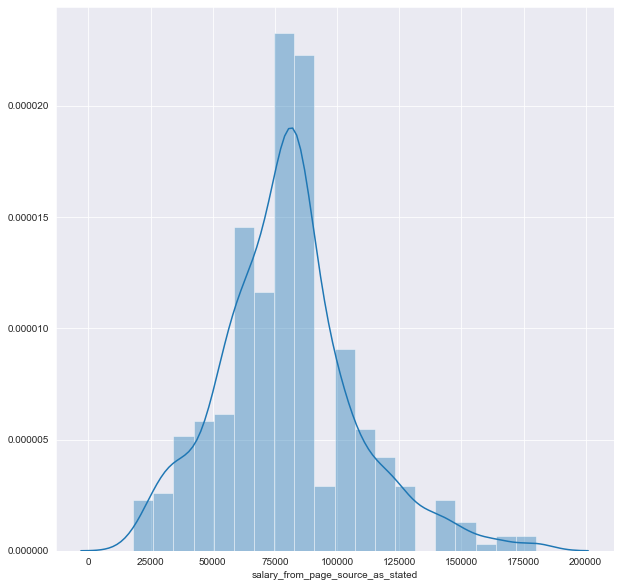

In [47]:
plt.figure(figsize=(10,10))
sns.distplot(merged_jobs_reset.salary_from_page_source_as_stated.loc[merged_jobs_reset.salary_from_page_source_time_period=='Y'], bins=20)
plt.show();

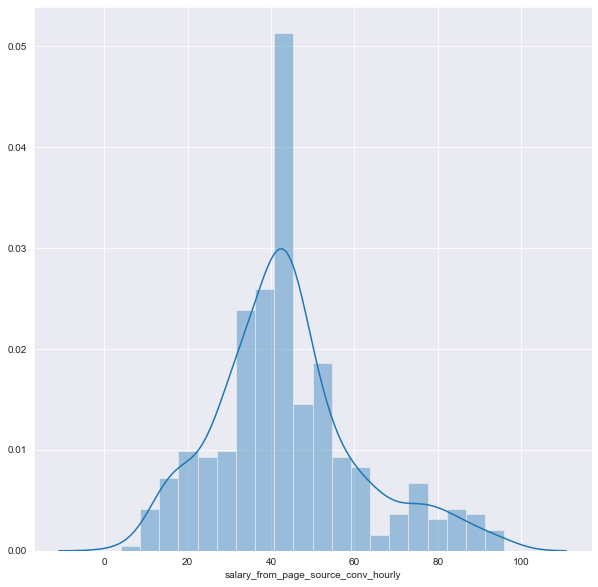

In [48]:
plt.figure(figsize=(10,10))
sns.distplot(merged_jobs_reset.salary_from_page_source_conv_hourly, bins=20)
plt.show();

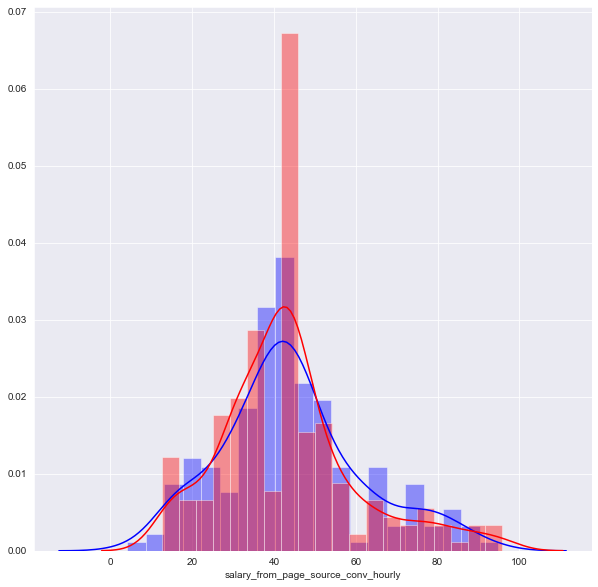

In [49]:
plt.figure(figsize=(10,10))
sns.distplot(merged_jobs_reset.loc[merged_jobs_reset['searched__data scientist']==1].salary_from_page_source_conv_hourly, color='b', label='DS', bins=20)
sns.distplot(merged_jobs_reset.loc[merged_jobs_reset['searched__machine learning engineer']==1].salary_from_page_source_conv_hourly, color='r', label='MLeng', bins=20)
plt.show();

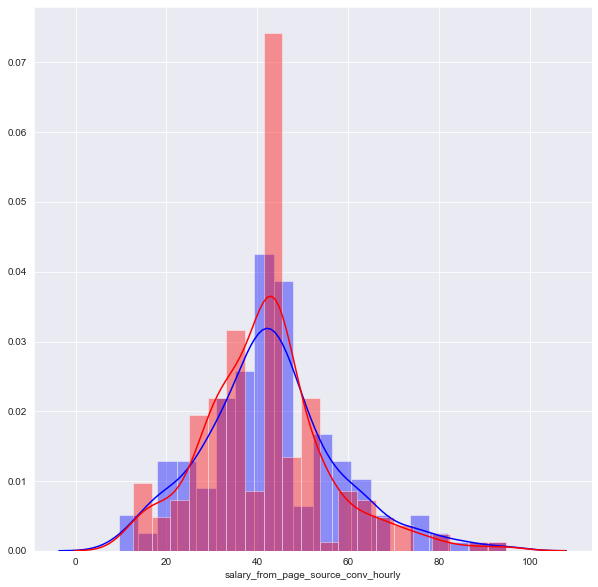

In [50]:
plt.figure(figsize=(10,10))
sns.distplot(merged_jobs_reset.loc[((merged_jobs_reset['searched__data scientist']==1) & (merged_jobs_reset.salary_from_page_source_time_period=='Y'))].salary_from_page_source_conv_hourly, color='b', label='DS', bins=20)
sns.distplot(merged_jobs_reset.loc[((merged_jobs_reset['searched__machine learning engineer']==1) & (merged_jobs_reset.salary_from_page_source_time_period=='Y'))].salary_from_page_source_conv_hourly, color='r', label='MLeng', bins=20)
plt.show();

## 1.3 Number of reviews

A lot of the company title fields in our data have attached a "x reviews" to the end. Whilst we're not hugely interested in the number of reviews at the moment, we should first remove that string, and store it anyway as an additional piece of data.

In [51]:
t = '1 review'
re.findall('[0-9]*[,]*[0-9]* review[s]*', t)[-1]

'1 review'

In [52]:
def get_num_reviews(text, regex_pattern = '[0-9]*[,]*[0-9]* review[s]*'):
    """Function that should be applied across the elements of a column in a pandas dataframe. 
    Goes through the text trying to find a pattern for the number of reviews left using regex. 
    An occurrence of 0 will just return a nan
     Args:
     text - (str) input text
     regex_pattern - (str) pattern for regex to use for retrieving data
     
     Returns :
     num_review - a single
     """
    text = str(text)
    
    reviews = re.findall(regex_pattern, text)
    if reviews==[]:
        num_review_int= np.NaN
    else:
        num_review = reviews[-1]
        num_review_clean = re.sub(',', '', num_review)
        num_review_int = int(re.sub('review[s]*', '', num_review_clean))
    return num_review_int

In [53]:
merged_jobs_reset['Num_reviews'] = merged_jobs_reset.company.apply(get_num_reviews)

In [54]:
def remove_reviews(text, regex_pattern = '[0-9]*[,]*[0-9]* review[s]*'):
    return re.sub(regex_pattern, '', text)

merged_jobs_reset.company = merged_jobs_reset.company.apply(remove_reviews)

In [55]:
merged_jobs_reset.tail(20)

,company,job_title,job_descr,job_post_html,job_url,searched__data scientist,searched__machine learning engineer,salary_data,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews
1205,AWS EMEA SARL (UK Branch),Sr. Data Lab Architect,"Highly technical and analytical, possessing se...","[[[\n, <title>Sr. Data Lab Architect - London ...",https://www.indeed.co.uk/rc/clk?jk=380b2283fe4...,0,1,"(nan, nan, nan)",NaN,NaN,NaN,61681.0
1206,AWS EMEA SARL (UK Branch),Principal Data Lab Architect,"Highly technical and analytical, possessing 10...","[[[\n, <title>Principal Data Lab Architect - L...",https://www.indeed.co.uk/rc/clk?jk=05918210a88...,0,1,"(nan, nan, nan)",NaN,NaN,NaN,61681.0
1207,Mars,Senior Big Data Engineer - Procurement Team,What you’ll do\n\nKeeping the data flowing and...,"[[[\n, <title>Senior Big Data Engineer - Procu...",https://www.indeed.co.uk/rc/clk?jk=0782b9ba612...,0,1,"(nan, nan, nan)",NaN,NaN,NaN,1755.0
1208,SeedLegals,"Back-end Engineer: Spring, Kotlin/Java",SeedLegals is London’s hottest lawtech startup...,"[[[\n, <title>Back-end Engineer: Spring, Kotli...",https://www.indeed.co.uk/rc/clk?jk=117f5fa0cf3...,0,1,"(80000.0, 42.14963119072708, Y)",80000.0,42.15,Y,NaN
1209,Ravelin,Front-End Developer,Ravelin is pioneering the use of machine learn...,"[[[\n, <title>Front-End Developer - London - I...",https://www.indeed.co.uk/rc/clk?jk=5e06a69b04f...,0,1,"(nan, nan, nan)",NaN,NaN,NaN,NaN
1210,Uswitch,Product Manager - App,"At RVU, we have the best of both worlds; the e...","[[[\n, <title>Product Manager - App - London -...",https://www.indeed.co.uk/rc/clk?jk=e91b6d310b7...,0,1,"(nan, nan, nan)",NaN,NaN,NaN,8.0
1211,Cortex IT Recruitment,Senior DevOps,The Company\nThis is an international software...,"[[[\n, <title>Senior DevOps - London - Indeed....",https://www.indeed.co.uk/rc/clk?jk=22bb311dc38...,0,1,"(85000.0, 44.78398314014753, Y)",85000.0,44.78,Y,2.0
1212,Amazon UK Services Ltd.,"Senior Manager, Supply Chain Data Science EU",A Master Degree in a highly quantitative field...,"[[[\n, <title>Senior Manager, Supply Chain Dat...",https://www.indeed.co.uk/rc/clk?jk=fb4e161a314...,0,1,"(nan, nan, nan)",NaN,NaN,NaN,61681.0
1213,Uswitch,Senior Software Engineer - Platform,"Why us?\nAt RVU, we have the best of both worl...","[[[\n, <title>Senior Software Engineer - Platf...",https://www.indeed.co.uk/rc/clk?jk=51c3eed99bb...,0,1,"(nan, nan, nan)",NaN,NaN,NaN,8.0
1214,Linux Recruit,Senior Linux/DevOps Engineer with focus on Big...,Want to jump on the Machine Learning and Artif...,"[[[\n, <title>Senior Linux/DevOps Engineer wit...",https://www.indeed.co.uk/rc/clk?jk=2c310c7e0a0...,0,1,"(75000.0, 39.51527924130664, Y)",75000.0,39.52,Y,NaN


<a id=text ><a/> 

## 2. Cleaning text data
    
[LINK to table of contents](#contents)
    
We will preprocess the text data by removing any emails, websites and lemmatizing our text.

In [56]:
stop_words += list(string.punctuation)
lemmy = WordNetLemmatizer()


In [57]:
def preprocess_data(string):
    """As a precautionary measure we should try to remove any emails or websites that BS4 missed"""
    new_str = re.sub(r"\S+@\S+", '', string)
    new_str = re.sub(r"\S+.co\S+", '', new_str)
    new_str = re.sub(r"\S+.ed\S+", '', new_str)
    new_str_tok = tokenizer.tokenize(new_str)
    new_str_lemm = [lemmy.lemmatize(token) for token in new_str_tok]
    new_str_cont = ''
    for tok in new_str_lemm:
        new_str_cont += tok + ' '
    return new_str_cont

In [58]:
merged_jobs_reset.job_descr = merged_jobs_reset.job_descr.apply(preprocess_data)

In [59]:
merged_jobs_reset.head()

,company,job_title,job_descr,job_post_html,job_url,searched__data scientist,searched__machine learning engineer,salary_data,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,would like reassure all applicant that recruit...,"[[[\n, <title>CPRD Data Scientist - London - I...",https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0,"(39853.0, 20.99736564805058, Y)",39853.0,21.00,Y,18.0
1,PwC,Deals - Investigative Analytics - Data Scienti...,career within Forensics Technology service wil...,"[[[\n, <title>Deals - Investigative Analytics ...",https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0,"(nan, nan, nan)",NaN,NaN,NaN,7678.0
2,Capital One - UK,Data Scientist - Cyber,White Collar Factory 95009 United Kingdom Lond...,"[[[\n, <title>Data Scientist - Cyber - London ...",https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,1,0,"(nan, nan, nan)",NaN,NaN,NaN,8902.0
3,Globant,Lead Data Scientist,are digitally native technology where innovati...,"[[[\n, <title>Lead Data Scientist - London EC1...",https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,1,0,"(nan, nan, nan)",NaN,NaN,NaN,NaN
4,UK Government - National Crime Agency,G4 Lead Data Scientist - Cyber,Deploy analytical capability support operation...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,1,0,"(35846.0, 18.886195995785037, Y)",35846.0,18.89,Y,32.0


Before unloading the data we will do one final visualization of the whole dataframe's text.

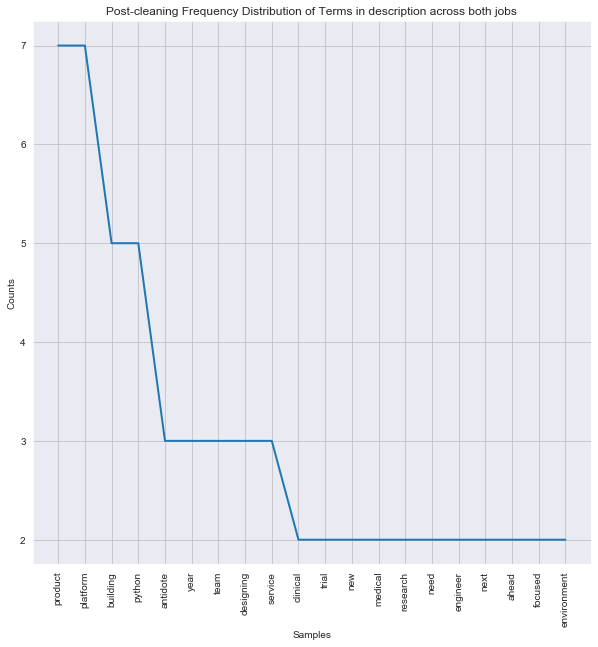

In [60]:
plot_freqdist_from_series(merged_jobs_reset.job_descr, tokenizer, new_stop_words, title='Post-cleaning Frequency Distribution of Terms in description across both jobs')

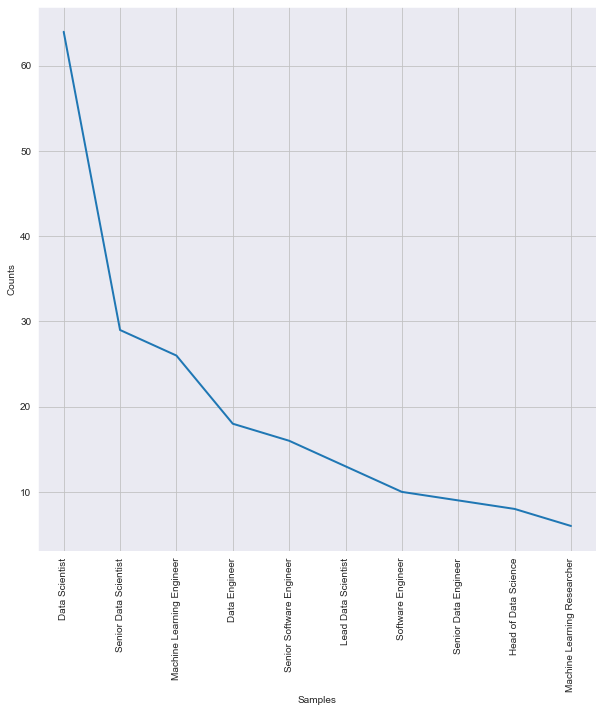

In [61]:
plt.figure(figsize=(10,10))
FreqDist(merged_jobs_reset.job_title.values).plot(10)

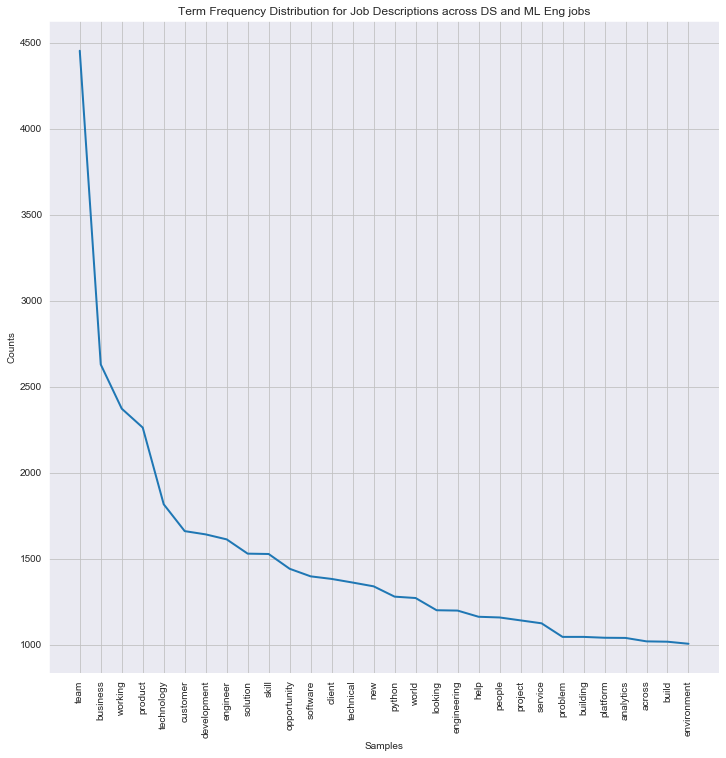

In [62]:
all_descr= ''
for string in merged_jobs_reset.job_descr.tolist():
    tokenized_str = tokenizer.tokenize(string)
    for word in tokenized_str:
        word = word.lower()
        if word not in stop_words:
            all_descr += (word) + ' '        
    
plt.figure(figsize=(12,12))
plt.title( 'Term Frequency Distribution for Job Descriptions across DS and ML Eng jobs')    

FreqDist(all_descr.split(' ')).plot(30)

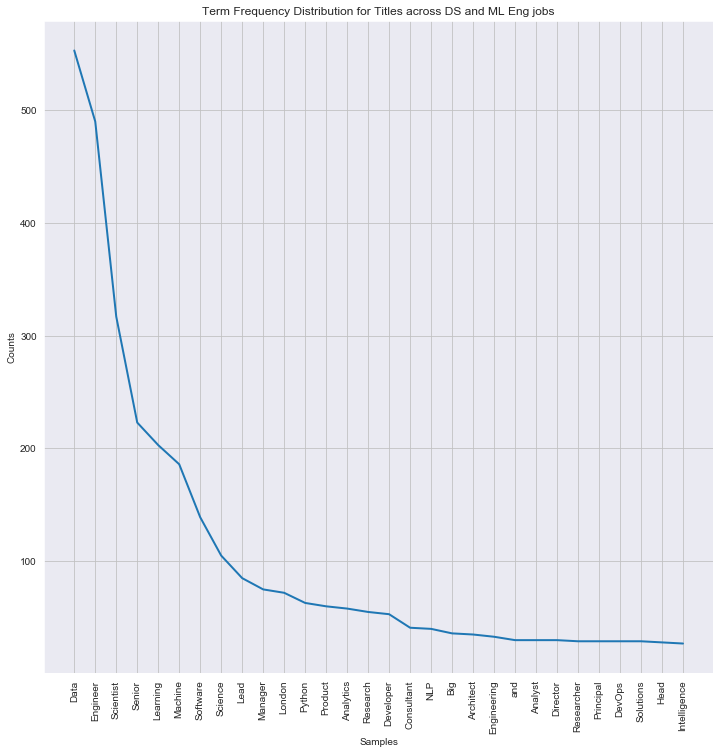

In [63]:
all_titles= ''
for string in merged_jobs_reset.job_title.tolist():
    tokenized_str = tokenizer.tokenize(string)
    for word in tokenized_str:
        all_titles += (word) + ' '        
plt.figure(figsize=(12,12))
plt.title( 'Term Frequency Distribution for Titles across DS and ML Eng jobs')    

FreqDist(all_titles.split(' ')).plot(30)

In [64]:
clean_data = merged_jobs_reset.drop(columns=['job_post_html'])

In [65]:
clean_data.head()

,company,job_title,job_descr,job_url,searched__data scientist,searched__machine learning engineer,salary_data,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,would like reassure all applicant that recruit...,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0,"(39853.0, 20.99736564805058, Y)",39853.0,21.00,Y,18.0
1,PwC,Deals - Investigative Analytics - Data Scienti...,career within Forensics Technology service wil...,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0,"(nan, nan, nan)",NaN,NaN,NaN,7678.0
2,Capital One - UK,Data Scientist - Cyber,White Collar Factory 95009 United Kingdom Lond...,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,1,0,"(nan, nan, nan)",NaN,NaN,NaN,8902.0
3,Globant,Lead Data Scientist,are digitally native technology where innovati...,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,1,0,"(nan, nan, nan)",NaN,NaN,NaN,NaN
4,UK Government - National Crime Agency,G4 Lead Data Scientist - Cyber,Deploy analytical capability support operation...,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,1,0,"(35846.0, 18.886195995785037, Y)",35846.0,18.89,Y,32.0


In [67]:
import sqlite3 
conn = sqlite3.connect('jobs_database.db')
cur = conn.cursor()


In [68]:
merged_jobs_reset.head(2)

,company,job_title,job_descr,job_post_html,job_url,searched__data scientist,searched__machine learning engineer,salary_data,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,would like reassure all applicant that recruit...,"[[[\n, <title>CPRD Data Scientist - London - I...",https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0,"(39853.0, 20.99736564805058, Y)",39853.0,21.0,Y,18.0
1,PwC,Deals - Investigative Analytics - Data Scienti...,career within Forensics Technology service wil...,"[[[\n, <title>Deals - Investigative Analytics ...",https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0,"(nan, nan, nan)",NaN,NaN,NaN,7678.0


In [71]:
import mysql.connector

In [106]:
jobs_db = mysql.connector.connect(
                                host='localhost',
                                user='root',
                                passwd='ergonomic keyboard', 
                                )

print(jobs_db)

In [100]:
cur = jobs_db.cursor()

In [78]:
merged_jobs_final = merged_jobs_reset.drop(columns=['job_post_html', 'salary_data'])

In [94]:
merged_jobs_final.head()

,company,job_title,job_descr,job_url,searched__data scientist,searched__machine learning engineer,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,would like reassure all applicant that recruit...,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0,39853.0,21.00,Y,18.0
1,PwC,Deals - Investigative Analytics - Data Scienti...,career within Forensics Technology service wil...,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0,NaN,NaN,NaN,7678.0
2,Capital One - UK,Data Scientist - Cyber,White Collar Factory 95009 United Kingdom Lond...,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,1,0,NaN,NaN,NaN,8902.0
3,Globant,Lead Data Scientist,are digitally native technology where innovati...,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,1,0,NaN,NaN,NaN,NaN
4,UK Government - National Crime Agency,G4 Lead Data Scientist - Cyber,Deploy analytical capability support operation...,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,1,0,35846.0,18.89,Y,32.0


In [87]:
from pandas.io import sql
import pymysql


# import MySQLdb

In [91]:
merged_jobs_final.to_sql(name='jobs',
                         con = jobs_db)

DatabaseError: Execution failed on sql 'SELECT name FROM sqlite_master WHERE type='table' AND name=?;': Not all parameters were used in the SQL statement

In [109]:
cur.execute("""CREATE DATABASE JobsDatabase""")

In [144]:
jobs_db = mysql.connector.connect(
                                host='localhost',
                                user='root',
                                passwd='ergonomic keyboard', 
                                database='JobsDatabase'
                                )

cur = jobs_db.cursor()

cur.execute("""SHOW TABLES""")
for x in cur:
    print(x)

('Jobs',)
('test_jobs',)


In [159]:
#Creating the jobs table
cur.execute("""ALTER TABLE Jobs (
                                'id' INTEGER PRIMARY KEY AUTOINCREMENT,
                                'company' TEXT,
                                'job_title' TEXT,
                                'job_descr' TEXT,
                                'job_url' TEXT,
                                'searched__data_scientist' INTEGER,
                                'searched__machine_learning_engineer' INTEGER,
                                'salary_from_page_source_as_stated' FLOAT,
                                'salary_from_page_source_conv_hourly' FLOAT,
                                'salary_from_page_source_time_period' TEXT,
                                'Num_reviews' INT
                                )          
            """)

ProgrammingError: 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near '(
                                'id' INTEGER PRIMARY KEY AUTOINCREMENT,
      ' at line 1

In [142]:
cur.execute("""SHOW COLUMNS FROM Jobs""")


# Fetch all the records
result = cur.fetchall()
for i in result:
    print(i)

('id', 'int', 'NO', 'PRI', None, '')
('company', 'text', 'YES', '', None, '')
('job_title', 'text', 'YES', '', None, '')
('job_descr', 'text', 'YES', '', None, '')
('job_url', 'text', 'YES', '', None, '')
('searched__data_scientist', 'int', 'YES', '', None, '')
('searched__machine_learning_engineer', 'int', 'YES', '', None, '')
('salary_from_page_source_as_stated', 'float', 'YES', '', None, '')
('salary_from_page_source_conv_hourly', 'float', 'YES', '', None, '')
('salary_from_page_source_time_period', 'text', 'YES', '', None, '')
('Num_reviews', 'int', 'YES', '', None, '')


In [124]:
merged_jobs_final.rename(columns={'searched__data scientist':'searched__data_scientist', 'searched__machine learning engineer':'searched__machine_learning_engineer'}, inplace=True)

In [147]:
merged_jobs_final['id'] = merged_jobs_final.index

array([False, False, False, ..., False, False, False])

In [150]:
merged_jobs_final.head()

,company,job_title,job_descr,job_url,searched__data_scientist,searched__machine_learning_engineer,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews,id
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,would like reassure all applicant that recruit...,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0,39853.0,21.00,Y,18.0,0
1,PwC,Deals - Investigative Analytics - Data Scienti...,career within Forensics Technology service wil...,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0,NaN,NaN,NaN,7678.0,1
2,Capital One - UK,Data Scientist - Cyber,White Collar Factory 95009 United Kingdom Lond...,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,1,0,NaN,NaN,NaN,8902.0,2
3,Globant,Lead Data Scientist,are digitally native technology where innovati...,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,1,0,NaN,NaN,NaN,NaN,3
4,UK Government - National Crime Agency,G4 Lead Data Scientist - Cyber,Deploy analytical capability support operation...,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,1,0,35846.0,18.89,Y,32.0,4


In [152]:
cols = "`,`".join([str(i) for i in merged_jobs_final.columns.tolist()])

# Insert DataFrame recrds one by one.
for i,row in merged_jobs_final.iterrows():
    sql_command = "INSERT INTO `Jobs` (`" +cols + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
    cur.execute(sql_command, tuple(row))

    # the connection is not autocommitted by default, so we must commit to save our changes
    jobs_db.commit()

IntegrityError: 1062 (23000): Duplicate entry '0' for key 'jobs.PRIMARY'

In [160]:
# All seems good!

merged_jobs_final.to_csv('jobs.csv')